In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from math import sqrt
np.set_printoptions(suppress=True, precision=10)
Colors = ["#FF671F", "#046A38", "#06038D"]

In [ ]:
def kMeans(data, k, itrs=100):
    centroids = data[np.random.choice(len(data), k, replace=False)]
    for _ in range(itrs):
        labels = np.argmin(np.linalg.norm(data[:,np.newaxis] - centroids, axis=2, ord=2), axis=1)
        _centroids = np.array([data[labels==j].mean(axis=0) for j in range(k)])
        if np.allclose(centroids, _centroids, rtol=1e-4):
            break
        centroids = _centroids
    return centroids, labels

In [ ]:
def e_step(data, mu, cov, pi):
  R = np.zeros((len(data), len(mu)))
  for j in range(len(mu)):
      mvn = multivariate_normal(mean=mu[j], cov=cov[j])
      R[:,j] = pi[j]*mvn.pdf(data)
  R /= np.sum(R, axis=1, keepdims=True)
  return R

In [ ]:
def m_step(data, R):
  n_points, n_clusters = R.shape
  pi = np.sum(R, axis=0) / n_points
  mu = np.dot(R.T, data) / np.sum(R, axis=0, keepdims=True).T
  cov = [np.dot((data - mu[j]).T,(R[:,j][:,np.newaxis]*(data - mu[j]))) / np.sum(R[:,j]) for j in range(n_clusters)]
  return pi, mu, cov

In [ ]:
def log_likelihood(data, pi, mu, cov):
  n_clusters, n_points = len(mu), len(data)
  likelihood = np.zeros((len(data), len(mu)))
  for j in range(len(mu)):
      mvn = multivariate_normal(mean=mu[j], cov=cov[j])
      likelihood[:,j] = pi[j]*mvn.pdf(data)
  log_likelihood = np.sum(np.log(np.sum(likelihood, axis=1)))
  return log_likelihood

In [ ]:
def EM(data, k, itrs=100, eta=1e-4):
  pi = np.full(k, 1/k)
  mu, labels = kMeans(data, k)
  cov = [np.cov(data[labels==j].T) for j in range(k)]
  log_likelihood_list = []
  for i in range(itrs):
    R = e_step(data, mu, cov, pi)
    pi, mu, cov = m_step(data, R)
    log_likelihood_value = log_likelihood(data, pi, mu, cov)
    log_likelihood_list.append(log_likelihood_value)
    if i > 0 and np.abs(log_likelihood_list[i] - log_likelihood_list[i - 1]) < eta:
        break
  return pi, mu, cov, R, log_likelihood_list, labels

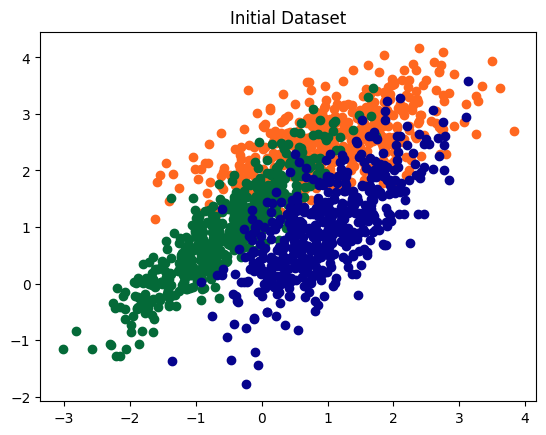

In [ ]:
n = 500
Mean = [[1,2.5],[-0.5,1],[1,1]]
Cov = np.random.rand(3, 2, 2)
for i in range(3):
  cov = np.array(Cov[i])
  cov = (cov + cov.T)/2.0
  l, v = np.linalg.eig(cov)
  D = np.array(np.diag(abs(l)))
  cov = v @ D @ np.linalg.inv(v)
  Cov[i] = cov
Pi = np.full(3, 1/3)
Points = {}
for i in range(3):
  Points[i] = np.random.multivariate_normal(mean=Mean[i], cov=Cov[i], size=n)
for i in range(3):
  X, Y = Points[i][:,0], Points[i][:,1]
  plt.scatter(X, Y, c=Colors[i])
plt.title("Initial Dataset")
plt.show()

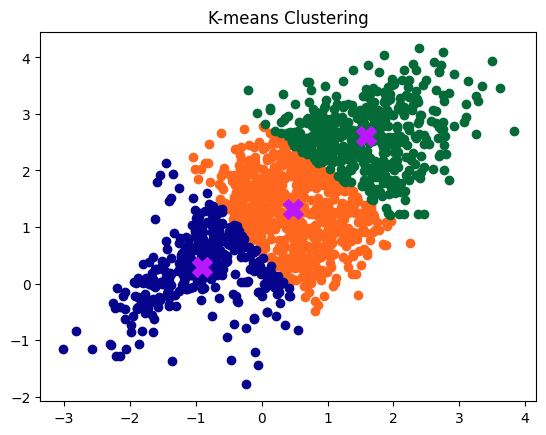

In [ ]:
data = np.vstack((Points[0], Points[1], Points[2]))
np.random.shuffle(data)
kMeans_centroids, kMeans_labels = kMeans(data, k=3)
for i in range(3):
  X, Y = data[kMeans_labels==i,0], data[kMeans_labels==i,1]
  plt.scatter(X, Y, c=Colors[i])
plt.scatter(kMeans_centroids[:, 0], kMeans_centroids[:, 1], marker='X', s=200, c='#bb17fc')
plt.title("K-means Clustering")
plt.show()

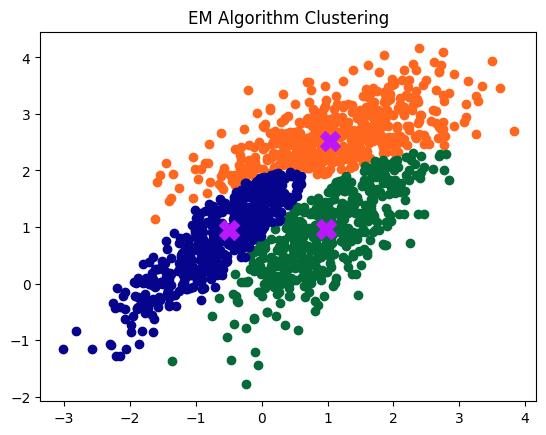

In [ ]:
EM_pi, EM_mu, EM_cov, EM_gamma, EM_log_likelihoods, EM_labels = EM(data, k=3)
for i in range(3):
    plt.scatter(data[EM_gamma[:,i] > 0.5,0], data[EM_gamma[:,i] > 0.5,1], c=Colors[i])
plt.scatter(EM_mu[:,0], EM_mu[:,1], marker='X', s=200, color='#bb17fc')
plt.title('EM Algorithm Clustering')
plt.show()

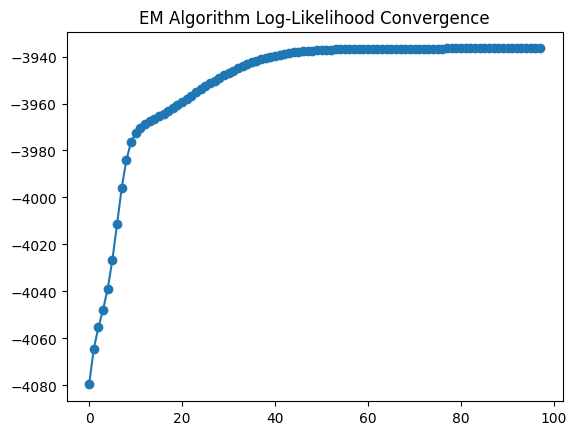

In [ ]:
plt.plot(range(len(EM_log_likelihoods)), EM_log_likelihoods, marker='o')
plt.title('EM Algorithm Log-Likelihood Convergence')
plt.show()